# **Laboratorio 8**
**Daniela Navas**

## **Task 1** - Teoría

**Responda las siguientes preguntas de forma clara y concisa, pueden subir un PDF o bien dentro del mismo Jupyter Notebook.**<br> 
**1. Investigar el algoritmo AC-3 y su relación con el algoritmo de backtracking search**<br>
El algoritmo AC-3 (Arc Consistency Algorithm #3) es un método utilizado en problemas de satisfacción de restricciones (CSPs). Fue desarrollado por Alan Mackworth en 19771. Su objetivo es asegurar que cada valor en el dominio de una variable tenga un valor correspondiente en el dominio de otra variable que satisfaga la restricción entre ellas.

Su relación con backtracking search es que AC-3 se utiliza para reducir los dominios de las variables antes de aplicar el backtracking. Esto significa que elimina valores que no pueden formar parte de ninguna solución válida, simplificando el problema. Backtracking search es un método de búsqueda que prueba diferentes combinaciones de valores para las variables y retrocede cuando encuentra una combinación que no cumple con las restricciones. Al combinar AC-3 con backtracking, se puede mejorar la eficiencia del proceso de búsqueda, ya que AC-3 reduce el espacio de búsqueda eliminando valores inconsistentes antes de que el backtracking comience2.

**2. Defina en sus propias palabras el término “Arc Consistency”**<br>
La consistencia de arco (Arc Consistency) se refiere a una propiedad en problemas de satisfacción de restricciones donde, para cada valor de una variable en su dominio, existe al menos un valor en el dominio de otra variable que satisface la restricción entre ellas. En palabras sencillas, un arco entre dos variables es consistente si todos los valores posibles de una variable tienen un valor correspondiente en la otra variable que cumple con la restricción.

---

## **Task 2** - CSP con Backtracking, Beam y Local Search 
En este ejercicio, implementará tres algoritmos diferentes de satisfacción de restricciones para resolver un problema de programación de exámenes para cuatro estudiantes que toman siete exámenes diferentes. El problema implica calendarizar los exámenes para los estudiantes respetando diversas limitaciones y preferencias.  

Restricciones: 
- Todos los exámenes deberán realizarse en días diferentes, concretamente lunes, martes y miércoles. 
- Ningún estudiante deberá tener más de un examen por día. 
- Los estudiantes que toman el mismo curso no pueden tener exámenes programados para el mismo día.

Para este ejercicio **puede utilizar librerías**, pero se sugiere intentar hacer los algoritmos por ustedes mismos. Para programar su solución pueden considerar (pero esto **no significa** que sea una guía definitiva)  lo siguiente: 
1. Definir las variables:<br>
    a. Definir variables que representen exámenes (cursos).<br>
    b. Defina el dominio para cada variable, especificando los días posibles (lunes, martes, miércoles) para cada examen.<br>
2. Definir las restricciones:<br>
    a. Defina restricciones para garantizar que todos los exámenes se realicen en días diferentes, que ningún estudiante tenga más de un examen por día y que los estudiantes que toman el mismo curso no tengan exámenes el mismo día.<br>
3. Implemente el algoritmo de backtracking search:<br>
    a. Implemente el algoritmo de backtracking search para encontrar una solución.<br>
    b. Utilice el retroceso para explorar el espacio de búsqueda y encontrar una asignación válida de variables.<br>
4. Implemente el algoritmo de beam search:<br>
    a. Implemente el algoritmo de beam search para encontrar una solución.<br>
    b. Utilice una heurística para seleccionar “caminos” prometedores y explorar el espacio de búsqueda de manera eficiente.<br>
5. Implemente el algoritmo de local search:<br>
    a. Implemente el algoritmo de local search para encontrar una solución.<br>
    b. Utilice una heurística para mejorar iterativamente la solución actual explorando soluciones vecinas.<br>

De cada uno de los algoritmos implementados, tome el tiempo que le toma encontrar una solución, y **compare** no solo el **tiempo**, sino también la **solución encontrada** de cada uno. Escriba sus conclusiones como parte de una celda “markdown” en su Jupyter Notebook.

In [123]:
%reset -f

In [124]:
# Definir las variables
examenes = ['Matemática', 'Lenguaje', 'Ciencias Naturales', 'Ciencias Sociales', # Lista de exámenes que deben programarse 
            'Inglés', 'Estadística', 'Contabilidad'] 
dias = ['Lunes', 'Martes', 'Miércoles'] # Días disponibles para programar los exámenes

# Definir dominio
dominios = {e: dias.copy() for e in examenes} # Cada examen puede asignarse a cualquiera de los días disponibles

# Lista de estudiantes y los exámenes que deben presentar
# Cada clave representa a un estudiante y el valor es la lista de exámenes que tiene inscritos
estudiantes = {
    'Est1': ['Matemática', 'Lenguaje', 'Ciencias Naturales'],
    'Est2': ['Ciencias Sociales', 'Inglés', 'Estadística'],
    'Est3': ['Contabilidad', 'Lenguaje', 'Matemática'],
    'Est4': ['Ciencias Naturales', 'Inglés', 'Ciencias Sociales']
}

# Recorrer el diccionario de estudiantes para reorganizar la información de manera que se asocia estudiantes a cada curso
cursos_estudiantes = {}
for est, cursos in estudiantes.items():
    for curso in cursos:
        if curso not in cursos_estudiantes:
            cursos_estudiantes[curso] = []  # Si el curso no está en el diccionario, se inicializa.
        cursos_estudiantes[curso].append(est)  # Agregar el estudiante a la lista de inscritos en el curso.

# Función para verificar si una asignación es válida según las restricciones.
def consistente(assignment):
    """
    Verifica si la asignación actual de exámenes a días cumple con las restricciones:
    1. Un estudiante no puede tener más de un examen en el mismo día.
    2. Los exámenes del mismo curso no deben estar en el mismo día para los estudiantes inscritos.
    
    Param:
    - assignment (dict): Diccionario con la asignación actual de exámenes a días.
    
    Return:
    - bool: True si la asignación es válida, False si viola alguna restricción.
    """
    # Restricción 1: Un estudiante no puede tener más de un examen en el mismo día.
    for est, exams in estudiantes.items():
        # Obtener los días en los que el estudiante tiene exámenes asignados.
        dias_est = [assignment[e] for e in exams if e in assignment]
        # Si hay exámenes en el mismo día, la asignación no es válida.
        if len(dias_est) != len(set(dias_est)):  # Si hay días repetidos, hay conflicto.
            return False

    # Restricción 2: Los exámenes de un mismo curso no pueden estar en el mismo día.
    for curso, estudiantes_curso in cursos_estudiantes.items():
        if curso not in assignment:  # Si el curso aún no está asignado, se ignora.
            continue
        dia_curso = assignment[curso]  # Día en el que el curso ha sido asignado.
        
        # Verificar que ningún estudiante de ese curso tenga otro examen el mismo día.
        for est in estudiantes_curso:
            otros_examenes = [e for e in estudiantes[est] if e != curso]  # Otros exámenes del estudiante.
            for examen in otros_examenes:
                if examen in assignment and assignment[examen] == dia_curso:
                    return False  # Hay conflicto si otro examen del estudiante está en el mismo día
    
    return True  # Si no se violan restricciones, la asignación es válida


### Backtracking Search

In [151]:
# Libreria para medir tiempos
import time

def backtracking(assignment, examenes_restantes):
    """
    Función principal de búsqueda con Backtracking
    
    Param:
    - assignment (dict): Diccionario con la asignación actual de exámenes a días.
    - examenes_restantes: Contador para asignar el máximo de examenes a cada estudiante en cada día
    
    Return:
    - resultado: Solución válida del problema
    """
    # Caso base: si ya no quedan exámenes por asignar, retornamos la asignación completa
    if not examenes_restantes:
        return assignment

    # Selección de la variable más restringida (MRV: Minimum Remaining Values)
    # Elegir el examen con el menor número de días disponibles en su dominio
    exam = min(examenes_restantes, key=lambda e: len(dominios[e]))

    for dia in orden_valores(assignment, exam): # Para cada valor (día) ordenado por menor cantidad de conflictos potenciales
        assignment[exam] = dia  # Asignar un día tentativamente al examen
        if consistente(assignment): # Verificar si la asignación parcial es consistente con las restricciones
            # Llamada recursiva con el resto de exámenes
            resultado = backtracking(assignment.copy(), [e for e in examenes_restantes if e != exam])
            if resultado:
                return resultado  # Si encontramos una solución válida, la retornamos
        del assignment[exam] # Si no fue válida, deshacemos la asignación (backtrack)
    return None # Si no se puede asignar el examen a ningún día válido, retorna None (fallo)

def orden_valores(assignment, exam):
    """
    Ordena los valores del dominio de un examen (los días) según la heurística de menor conflicto
    
    Param:
    - assignment (dict): Diccionario con la asignación actual de exámenes a días.
    - exam: Examen a evaluar
    
    Return:
    - Devuelve los días ordenados por cantidad de conflictos crecientes
    """
    return sorted(dominios[exam], key=lambda d: conflictos_posibles(assignment, exam, d))

def conflictos_posibles(assignment, exam, dia):
    """
    Calcula la cantidad de conflictos potenciales si asignamos el examen `exam` al día `dia`.
    Los conflictos se basan en otros exámenes que ya han sido asignados a ese día
    y que comparten estudiantes con este examen.
    """
    conflictos = 0
    for est in cursos_estudiantes.get(exam, []):  # Obtener los estudiantes que toman este examen
        # Contar cuántos otros exámenes del estudiante ya están asignados al mismo día
        asignados = sum(1 for e in estudiantes[est] if e in assignment and assignment[e] == dia)
        conflictos += asignados
    return conflictos

#  Medición de tiempo para Backtracking
start = time.perf_counter()  # Medir el tiempo de ejecución
bt_result = backtracking({}, examenes)
bt_time = time.perf_counter() - start

# Resultados
print("Backtracking Search")
print("Tiempo:", bt_time * 1000, "ms")


Backtracking Search
Tiempo: 0.17230003140866756 ms


---
### Beam Search 

In [150]:
def heuristica_estado(estado):
    """
    Función heurística para evaluar la calidad de un estado en Beam Search.
    
    Param:
    - estado: Asignación parcial de exámenes a días.
    
    Return:
    - Un valor que representa la calidad del estado (menor es mejor).
    """
    # La heurística cuenta cuántos exámenes aún no han sido asignados, priorizando los estados más completos.
    return sum(len(dominios[e]) for e in examenes if e not in estado)

def beam_search(beam_width):
    """
    Implementación del algoritmo Beam Search para la asignación de exámenes.
    
    Param:
    - beam_width (int): Número de estados a mantener en cada iteración (ancho del haz).
    
    Return:
    - Asignación válida de exámenes a días si se encuentra una solución, None si falla.
    """

    beam = [{}] # Inicializar el haz con un único estado vacío (ningún examen asignado aún)
    
    while True:
        nuevos_candidatos = []  # Lista para almacenar los nuevos estados generados.
        for estado in beam:  # Iterar sobre los estados actuales en el haz.
            vars_no_asignadas = [e for e in examenes if e not in estado] # Identificar los exámenes que aún no han sido asignados.
            if not vars_no_asignadas: # Si ya asignamos todos los exámenes, devolver la solución encontrada.
                return estado
    
            var = vars_no_asignadas[0] # Seleccionar la primera variable sin asignar (puede mejorarse con heurísticas).
            
            # Probar asignar cada valor posible en el dominio de la variable.
            for valor in dominios[var]:
                nuevo_estado = estado.copy()
                nuevo_estado[var] = valor  # Asignar provisionalmente el valor al examen.
                if consistente(nuevo_estado):  # Verificar si la asignación sigue siendo válida.
                    nuevos_candidatos.append(nuevo_estado)  # Agregar el nuevo estado como candidato.

        nuevos_candidatos.sort(key=heuristica_estado) # Ordenar los nuevos estados generados según una heurística.
        
        beam = nuevos_candidatos[:beam_width] # Mantener solo los mejores beam_width candidatos.
        
        if not beam: # Si no hay candidatos válidos en esta iteración, no hay solución posible
            return None

# Medición de tiempo para Beam Search
start = time.perf_counter()
beam_width = 3
beam_result = beam_search(beam_width)
beam_time = time.perf_counter() - start

# Resultados
print("Beam Search\nTiempo:", beam_time * 1000, "ms")


Beam Search
Tiempo: 0.3725000424310565 ms


---
### Local Search 

In [149]:
# Librerías 
import random

def calcular_conflictos(estado):
    """
    Calcula la cantidad total de conflictos en una asignación de exámenes.
    
    Param:
    - estado: Asignación actual de exámenes a días.
    
    Return:
    - int: Número total de conflictos.
    """
    conflictos = 0
    for est in estudiantes.values():  # Iterar sobre cada estudiante.
        dias = [estado[e] for e in est if e in estado]  # Días en los que tiene exámenes asignados.
        # Contar cuántos exámenes ocurren el mismo día (mayor a 1).
        conflictos += sum(max(0, dias.count(d) - 1) for d in set(dias))
    return conflictos

def contribucion_conflictos(estado, exam):
    """
    Calcula cuántos conflictos está generando un examen en la asignación actual.
    
    Param:
    - estado: Asignación actual de exámenes a días
    - exam: Examen a evaluar
    
    Return:
    - Número de conflictos causados por el examen.
    """
    if exam not in estado:
        return 0  # Si el examen no ha sido asignado, no contribuye a conflictos.
    
    total = 0
    for est in cursos_estudiantes.get(exam, []):  # Recorrer los estudiantes inscritos en este examen.
        # Contar cuántos exámenes del estudiante están asignados al mismo día.
        mismo_dia = sum(1 for e in estudiantes[est] if e in estado and estado[e] == estado[exam])
        total += max(0, mismo_dia - 1)  # Si hay más de un examen el mismo día, se cuenta el conflicto.
    
    return total

def conflictos_con_valor(estado, exam, nuevo_dia):
    """
    Evalúa cuántos conflictos se generarían si asignamos un nuevo día a un examen.
    
    Param:
    - estado: Asignación actual de exámenes a días.
    - exam: Examen que estamos evaluando.
    - nuevo_dia: Nuevo día propuesto para el examen.
    
    Return:
    - int: Número de conflictos generados con la nueva asignación.
    """
    temp = estado.copy()  # Copiar el estado actual.
    temp[exam] = nuevo_dia  # Asignar provisionalmente el nuevo día.
    return contribucion_conflictos(temp, exam)  # Calcular los conflictos con la nueva asignación.

def local_search(max_iter=5000, max_tries=5):
    """
    Algoritmo de Búsqueda Local para la asignación de exámenes a días.
    
    Param:
    - max_iter (int): Número máximo de iteraciones por intento.
    - max_tries (int): Número máximo de reinicios aleatorios en caso de no encontrar solución.
    
    Return:
    - Asignación válida si se encuentra una solución sin conflictos, None en caso contrario.
    """
    for _ in range(max_tries):  # Permitir múltiples intentos con reinicios aleatorios
        # Generar un estado inicial aleatorio asignando un día al azar a cada examen.
        estado = {e: random.choice(dias) for e in examenes}
        mejor_conflicto = float('inf')  # Inicializar el mejor número de conflictos.

        for _ in range(max_iter):  # Iterar hasta alcanzar el máximo de iteraciones.
            conflicto_actual = calcular_conflictos(estado)  # Calculamos conflictos actuales.
            if conflicto_actual == 0:  # Si no hay conflictos, hay encontrado una solución válida.
                return estado
            if conflicto_actual < mejor_conflicto: # Si es la mejor solución hasta ahora, se guarda.
                mejor_conflicto = conflicto_actual
                estado_mejor = estado.copy()
            
            # Identificar exámenes que están causando conflictos.
            vars_conflictivas = [e for e in examenes if contribucion_conflictos(estado, e) > 0]
            
            if not vars_conflictivas:  # Si no hay exámenes conflictivos, pasamos a la siguiente iteración.
                continue

            var = random.choice(vars_conflictivas) # Elegir aleatoriamente un examen conflictivo para modificar su asignación.
            
            mejor_dia = min(dias, key=lambda d: conflictos_con_valor(estado, var, d)) # Buscar el mejor día para ese examen, minimizando los conflictos.
            estado[var] = mejor_dia  # Asignar el nuevo día al examen.
        
        estado = estado_mejor.copy() # Si no hay una solución en max_iter iteraciones, volvemos al mejor estado conocido.
    
    return None  # Si después de max_tries intentos no hay solución, devolver None.

# Medición de tiempo para Búsqueda Local
start = time.perf_counter()
local_result = local_search()
local_time = time.perf_counter() - start

# Resultados
print("Local Search\nTiempo:", local_time * 1000, "ms")


Local Search
Tiempo: 0.5531000206246972 ms


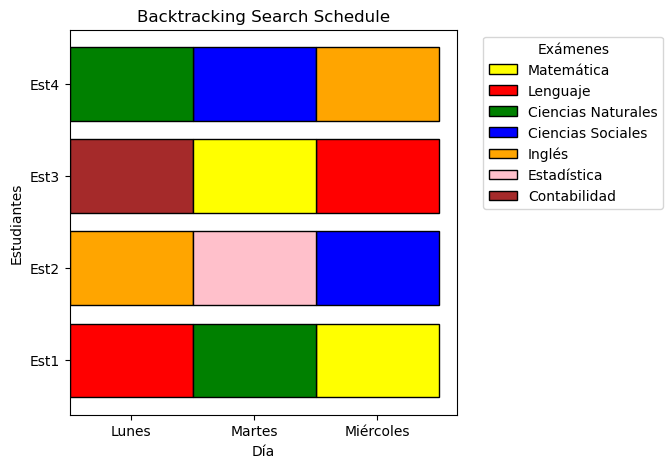

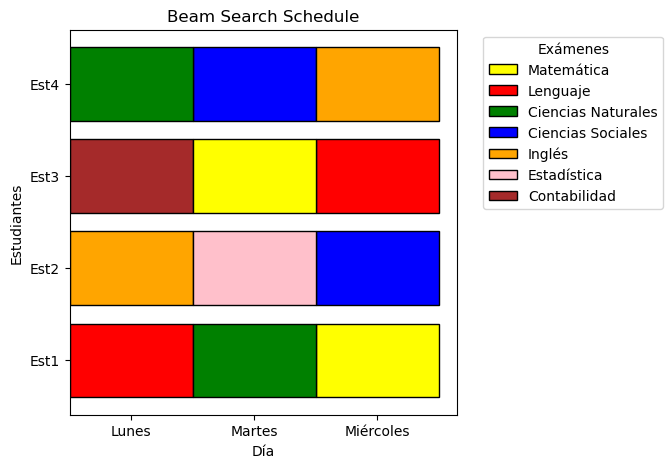

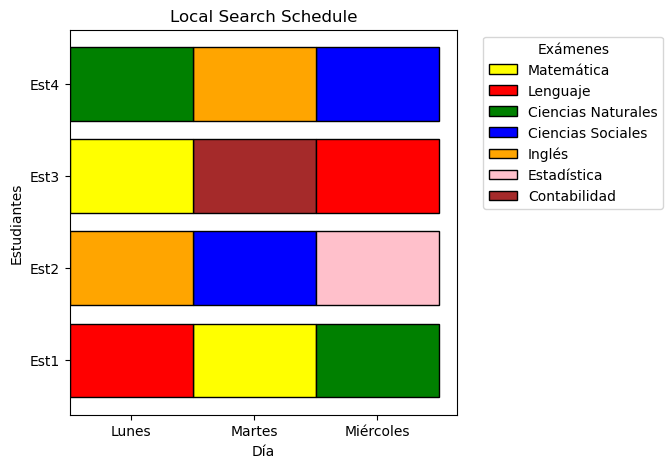

In [ ]:
# Librerias
import matplotlib.pyplot as plt

def plot_schedule(algoritmo, schedule):
    """
    Función para graficar los horarios de exámenes
    
    Param:
    - algoritmo: Nombre del algoritmo utilizado para la asignación.
    - schedule: Diccionario con la asignación de exámenes a días.
    """
    # Colores para cada examen
    colors = { 
        'Matemática': 'yellow', 'Lenguaje': 'red', 'Ciencias Naturales': 'green', 
        'Ciencias Sociales': 'blue', 'Inglés': 'orange', 'Estadística': 'pink', 
        'Contabilidad': 'brown'
    }
    
    # Diccionario donde almacenaremos los horarios de cada estudiante
    student_schedules = {student: {} for student in estudiantes}  
    
    # Rellenamos el diccionario con los exámenes asignados a cada estudiante
    for student, exams in schedule.items():  # Iterar sobre cada estudiante y su asignación
        for exam, day in exams.items():  # Iterar sobre los exámenes de cada estudiante
            student_schedules[student][day] = exam  # Asignamos el examen al día correspondiente

    # Crear la gráfica
    plt.figure(figsize=(5, 5))  
    used_labels = set()  # Evitar etiquetas duplicadas en la leyenda
    for student in estudiantes:  
        for day, exam in student_schedules[student].items():
            label = exam if exam not in used_labels else ""  
            plt.barh(student, 1, left=dias.index(day), color=colors[exam], edgecolor='black', label=label)
            used_labels.add(exam)  # Evitar que el examen se repita en la leyenda

    # Configuración del gráfico
    plt.xticks([x + 0.5 for x in range(len(dias))], dias)
    plt.title(f"{algoritmo} Schedule")
    plt.xlabel("Día")
    plt.ylabel("Estudiantes")
    plt.legend(title="Exámenes", bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1)
    plt.show()

# Mostrar gráficos para cada algoritmo si hay una solución disponible
if bt_result:
    plot_schedule("Backtracking Search", bt_result)
if beam_result:
    plot_schedule("Beam Search", beam_result)
if local_result:
    plot_schedule("Local Search", local_result)


---
#### **Tiempos de Ejecución** 

| Algoritmo            | Tiempo    |
|----------------------| --------- |
| Backtracking Search  | 0.1723 ms |
| Beam Search          | 0.3725 ms |
| Local Search         | 0.5531 ms |

#### **Conclusiones**
- Backtracking encontró una solución válida en el menor tiempo. Es eficiente para problemas pequeños, pero puede volverse ineficiente para problemas más grandes debido a su naturaleza exhaustiva.
- Beam Search tomó más tiempo que el Backtracking Search, también encontró una solución válida. Este algoritmo es útil para explorar caminos prometedores y puede ser más eficiente que el backtracking en problemas más grandes.
- Local Search  tomó el mayor tiempo para encontrar una solución, pero también encontró una solución válida. Es útil para mejorar iterativamente una solución y puede ser más efectivo en problemas donde se necesita una solución aproximada rápidamente.
- Los algoritmos de Backtracking y Beam Search encontraron soluciones iguales, probablemente porque ambos siguen enfoques sistemáticos y exhaustivos para explorar el espacio de búsqueda, garantizando encontrar una solución válida si existe. A diferencia de Local Search que utiliza un enfoque iterativo y heurístico, comenzando con una solución inicial y mejorándola iterativamente explorando soluciones vecinas. 

---

**GITHUB:**
https://github.com/danielanavas2002/InteligenciaArtificial/tree/main/Laboratorio/Laboratorio08

